In [1]:
import os

# do not prealocate memory
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

# Set cuda device to use
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
try:
    import matplotlib.pyplot as plt
except:
    !pip install matplotlib
    import matplotlib.pyplot as plt
try:
    import seaborn as sns
except:
    !pip install seaborn
    import seaborn as sns

%matplotlib inline
sns.set_theme(context='notebook', style='white', color_codes=True)

In [3]:
import jax.numpy as jnp
import jax.random as jr
import equinox as eqx
import optax
from blrax import ivon, noisy_value_and_grad, get_scale
from jax import lax, vmap, nn

key = jr.PRNGKey(0)

In [4]:
def compute_ece(logits, labels, num_bins=20):
    """Compute Expected Calibration Error"""
    probs = nn.softmax(logits, axis=-1)
    confidences = jnp.max(probs, axis=-1)
    predictions = jnp.argmax(probs, axis=-1)
    correct = predictions == labels
    
    # Create bins and compute ECE
    bin_boundaries = jnp.linspace(0, 1, num_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    
    def compute_bin_stats(bin_lower, bin_upper):
        in_bin = (confidences > bin_lower) & (confidences <= bin_upper)
        prop_in_bin = jnp.sum(in_bin)

        accuracy_in_bin = jnp.where(
            prop_in_bin > 0,
            jnp.sum(correct * in_bin) / prop_in_bin,
            0.
        )
        avg_confidence_in_bin = jnp.where(
            prop_in_bin > 0,
            jnp.sum(confidences * in_bin) / prop_in_bin,
            0.
        )
        return prop_in_bin * jnp.abs(accuracy_in_bin - avg_confidence_in_bin) / len(in_bin)
    
    ce = [compute_bin_stats(bin_lower, bin_upper)
            for bin_lower, bin_upper in zip(bin_lowers, bin_uppers)]
    ece = jnp.stack(ce).mean() 
    return ece

def standardize(train_images, test_images, num_channels=1):
    mean = train_images.reshape(-1, num_channels).mean(0)
    std = train_images.reshape(-1, num_channels).std(0)

    return (train_images - mean) / std, (test_images - mean) / std

def load_mnist():
    """
    Load MNIST dataset using only numpy and JAX.
    
    Returns:
        tuple: (train_ds, test_ds) where each is a dict containing 'image' and 'label'
    """
    import numpy as np
    import gzip
    import os
    from urllib import request

    def download_file(url, filename):
        if not os.path.exists(filename):
            print(f"Downloading {filename}...")
            request.urlretrieve(url, filename)

    # MNIST dataset URLs (using a mirror)
    base_url = "https://storage.googleapis.com/cvdf-datasets/mnist/"
    urls = {
        'train_images': base_url + 'train-images-idx3-ubyte.gz',
        'train_labels': base_url + 'train-labels-idx1-ubyte.gz',
        'test_images': base_url + 't10k-images-idx3-ubyte.gz',
        'test_labels': base_url + 't10k-labels-idx1-ubyte.gz'
    }

    # Create data directory if it doesn't exist
    os.makedirs('data', exist_ok=True)

    # Download files
    files = {}
    for key, url in urls.items():
        filename = os.path.join('data', f'mnist_{key}.gz')
        download_file(url, filename)
        files[key] = filename

    # Load data
    def load_images(filename):
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
        return data.reshape(-1, 28, 28)

    def load_labels(filename):
        with gzip.open(filename, 'rb') as f:
            return np.frombuffer(f.read(), np.uint8, offset=8)

    # Load and convert to JAX arrays
    train, test = standardize(
        jnp.array(load_images(files['train_images'])[..., None], dtype=jnp.float32),
        jnp.array(load_images(files['test_images'])[..., None], dtype=jnp.float32) 
    )
    train_ds = {
        'image': train,
        'label': jnp.array(load_labels(files['train_labels']), dtype=jnp.int32)
    }
    
    test_ds = {
        'image': test,
        'label': jnp.array(load_labels(files['test_labels']), dtype=jnp.int32)
    }

    return train_ds, test_ds

train_ds, test_ds = load_mnist()

In [5]:
def run_training(key, nnet, optim, train_ds, test_ds, mc_samples=1, num_epochs=10, batch_size=128, method='sequential'):
    """
    Train a neural network on MNIST using Equinox and Optax.
    
    Args:
        key: JAX PRNG key
        nnet: Equinox neural network
        optim: Optax (or blrax) optimizer
        train_ds: Training dataset dictionary with 'image' and 'label' keys
        test_ds: Test dataset dictionary with 'image' and 'label' keys
        num_epochs: Number of epochs to train
        batch_size: Batch size for training
    """
    
    # Initialize optimizer state
    params, static = eqx.partition(nnet, eqx.is_array)
    opt_state = optim.init(params)
    n_samples = len(train_ds['image'])
    steps_per_epoch = n_samples // batch_size
    
    # Cross entropy loss function
    def loss_fn(params, x, y, *args):
        model = eqx.combine(params, static)
        logits = vmap(model)(x)
        return optax.softmax_cross_entropy_with_integer_labels(logits, y).mean()
    
    # Training step function
    @eqx.filter_jit
    def train_step(key, loss_fn, params, opt_state, x, y):
        loss_value, grads, opt_state = noisy_value_and_grad(loss_fn, opt_state, params, key, x, y, mc_samples=mc_samples, method=method)
        updates, opt_state = optim.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state, loss_value
    
    # Evaluation function
    @eqx.filter_jit
    def evaluate(params, images, labels):
        model = eqx.combine(params, static)
        logits = vmap(model)(images)
        predictions = jnp.argmax(logits, axis=1)
        acc = jnp.mean(predictions == labels)
        nll = optax.softmax_cross_entropy_with_integer_labels(logits, labels).mean()
        ece = compute_ece(logits, labels)
        return acc, nll, ece
    
    # Inner training loop (one epoch)
    def train_epoch(carry, key):
        params, opt_state = carry
        
        # Shuffle training data
        key, _key = jr.split(key)
        perm = jr.permutation(_key, n_samples)
        train_images = train_ds['image'][perm]
        train_labels = train_ds['label'][perm]
        
        def train_step_scan(carry, xs):
            params, opt_state, key = carry
            
            batch_images, batch_labels = xs
            key, _key = jr.split(key)
            params, opt_state, loss_value = train_step(
                _key, loss_fn, params, opt_state, batch_images, batch_labels
            )
            return (params, opt_state, key), loss_value
        
        # Run training steps for one epoch
        data = (
            train_images[:steps_per_epoch * batch_size].reshape(steps_per_epoch, batch_size, -1),
            train_labels[:steps_per_epoch * batch_size].reshape(steps_per_epoch, batch_size)
        )
        init_carry = (params, opt_state, key)
        (params, opt_state, _), losses = lax.scan(
            train_step_scan,
            init_carry,
            data
        )
        
        # Calculate metrics
        acc, nll, ece = evaluate(
            params,
            test_ds['image'].reshape(-1, 28*28),
            test_ds['label']
        )
        
        metrics = {
            'loss': losses.sum() / steps_per_epoch,
            'acc': acc,
            'ece': ece,
            'nll': nll
        }
        
        return (params, opt_state), metrics
    
    # Run training for multiple epochs
    keys = jr.split(key, num_epochs)
    init_carry = (params, opt_state)
    (params, final_opt_state), metrics = lax.scan(
        train_epoch,
        init_carry,
        keys
    )
    trained_model = eqx.combine(params, static)
    return trained_model, final_opt_state, metrics


def plot_performance(results, num_epochs):
    fig, axes = plt.subplots(1, 3, figsize=(16, 4), sharex=True)

    for key in results:
        vals = results[key]
        if vals is not None:
            for ax, lbl in zip(axes, ['acc', 'ece', 'nll']):
                ax.plot(range(1, num_epochs + 1), vals[lbl], 'o:', label=key)
                ax.set_xlabel('epoch')
                ax.set_title(lbl)

    axes[0].legend(title='method', fontsize=12)
    axes[0].set_ylim([.95, 1.])
    fig.tight_layout()

    return fig

# DenseNet

In [6]:
depth = 3
in_size = 28 * 28
out_size = 10
num_neurons = 50
num_epochs = 100

key, _key = jr.split(key)
nnet = eqx.nn.MLP(in_size, out_size, num_neurons, depth, key=_key)

In [7]:
key, _key = jr.split(key)
optim = optax.adamw(learning_rate=1e-3)
trained_nnet, final_opt_state, metrics1 = run_training(_key, nnet, optim, train_ds, test_ds, num_epochs=50)

key, _key = jr.split(key)
optim = optax.adabelief(learning_rate=1e-3)
trained_nnet, final_opt_state, metrics2 = run_training(_key, nnet, optim, train_ds, test_ds, num_epochs=50)

key, _key = jr.split(key)
optim = optax.lion(learning_rate=1e-4, weight_decay=0.)
trained_nnet, final_opt_state, metrics3 = run_training(_key, nnet, optim, train_ds, test_ds, num_epochs=50)

2025-07-01 15:38:41.656624: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-07-01 15:38:41.656660: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-07-01 15:38:41.656683: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-07-01 15:38:41.656693: W external/xla/xla/service/gpu/au

In [8]:
datasize = len(train_ds['image'])
optim = ivon(
    1e-1,
    ess=datasize,
    hess_init=1.0,
    weight_decay=1e-3
)

In [9]:
key, _key = jr.split(key)
_, final_opt_state, metrics4 = run_training(_key, nnet, optim, train_ds, test_ds, num_epochs=50)

In [10]:
key, _key = jr.split(key)
_, final_opt_state, metrics5 = run_training(_key, nnet, optim, train_ds, test_ds, num_epochs=50, method='parallel')

2025-07-01 15:39:09.308258: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-07-01 15:39:09.308325: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-07-01 15:39:09.308355: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-07-01 15:39:09.308374: W external/xla/xla/service/gpu/au

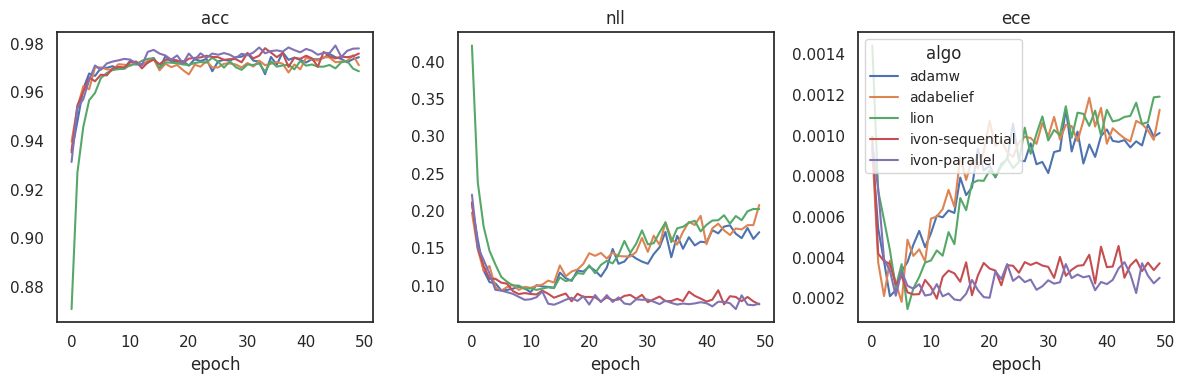

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for i, name in enumerate(['acc', 'nll', 'ece']):
    axes[i].plot(metrics1[name], label='adamw')
    axes[i].plot(metrics2[name], label='adabelief')
    axes[i].plot(metrics3[name], label='lion')
    axes[i].plot(metrics4[name], label='ivon-sequential')
    axes[i].plot(metrics5[name], label='ivon-parallel')
    axes[i].set_title(name)
    axes[i].set_xlabel('epoch')

plt.legend(title='algo', fontsize=10)
fig.tight_layout()

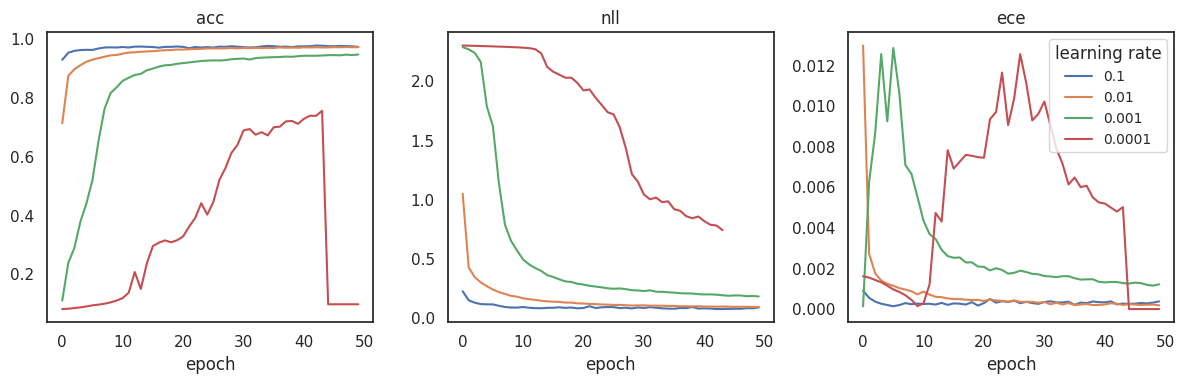

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for lr in [1e-1, 1e-2, 1e-3, 1e-4]:
    optim = ivon(
        lr,
        ess=datasize,
        hess_init=1.0,
        weight_decay=1e-3
    )

    key, _key = jr.split(key)
    _, _, metrics = run_training(_key, nnet, optim, train_ds, test_ds, num_epochs=50, mc_samples=1, method='parallel')
    for j, name in enumerate(['acc', 'nll', 'ece']):
        axes[j].plot(metrics[name], label=f'{lr}')
        axes[j].set_title(name)
        axes[j].set_xlabel('epoch')

plt.legend(title='learning rate', fontsize=10)
fig.tight_layout()

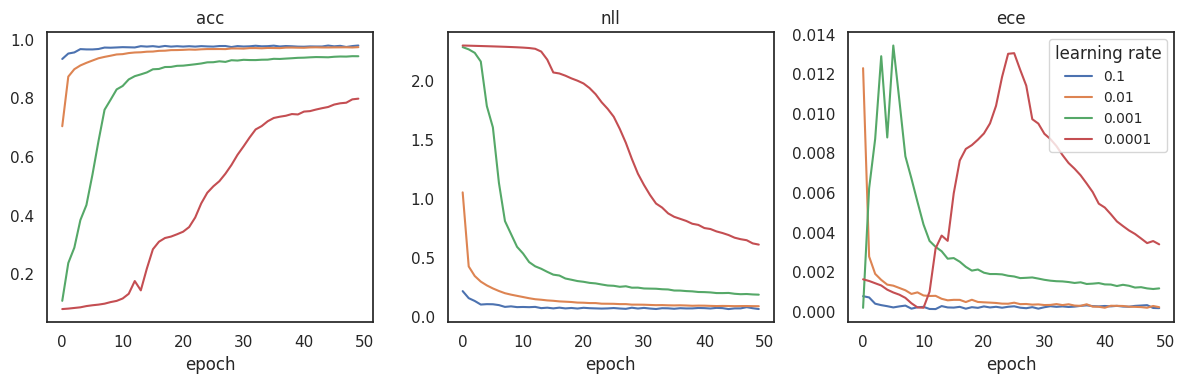

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for lr in [1e-1, 1e-2, 1e-3, 1e-4]:
    optim = ivon(
        lr,
        ess=datasize,
        hess_init=1.0,
        weight_decay=1e-3
    )

    key, _key = jr.split(key)
    _, _, metrics = run_training(_key, nnet, optim, train_ds, test_ds, num_epochs=50, mc_samples=4, method='parallel')
    for j, name in enumerate(['acc', 'nll', 'ece']):
        axes[j].plot(metrics[name], label=f'{lr}')
        axes[j].set_title(name)
        axes[j].set_xlabel('epoch')

plt.legend(title='learning rate', fontsize=10)
fig.tight_layout()

2025-07-01 15:40:10.237692: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-07-01 15:40:10.237733: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-07-01 15:40:10.237767: W external/xla/xla/service/gpu/autotuning/dot_search_space.cc:200] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs?Working around this by using the full hints set instead.
2025-07-01 15:40:10.237781: W external/xla/xla/service/gpu/au

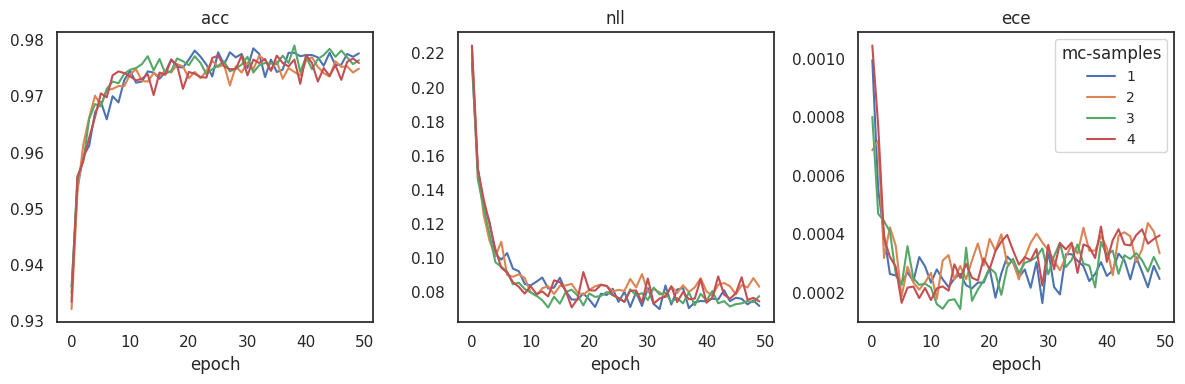

In [13]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

optim = ivon(
    1e-1,
    ess=datasize,
    hess_init=1.0,
    weight_decay=1e-3
)

for mc in [1, 2, 3, 4]:
    key, _key = jr.split(key)
    _, _, metrics = run_training(_key, nnet, optim, train_ds, test_ds, num_epochs=50, mc_samples=mc, method='parallel')
    for j, name in enumerate(['acc', 'nll', 'ece']):
        axes[j].plot(metrics[name], label=f'{mc}')
        axes[j].set_title(name)
        axes[j].set_xlabel('epoch')

plt.legend(title='mc-samples', fontsize=10)
fig.tight_layout()

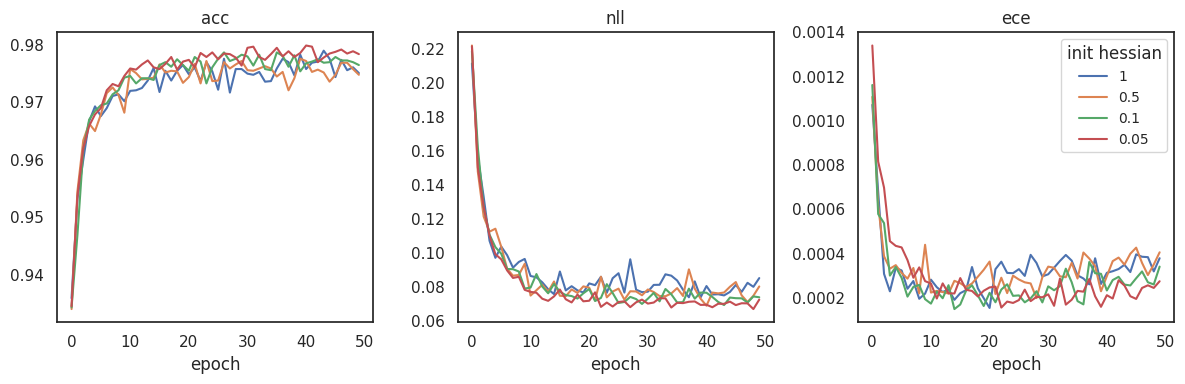

In [17]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for h0 in [1, .5, .1, .05]:
    optim = ivon(
        1e-1,
        ess=datasize,
        hess_init=h0,
        weight_decay=1e-3
    )

    key, _key = jr.split(key)
    _, _, metrics = run_training(_key, nnet, optim, train_ds, test_ds, num_epochs=50, mc_samples=1)
    for j, name in enumerate(['acc', 'nll', 'ece']):
        axes[j].plot(metrics[name], label=f'{h0}')
        axes[j].set_title(name)
        axes[j].set_xlabel('epoch')

plt.legend(title='init hessian', fontsize=10)
fig.tight_layout()

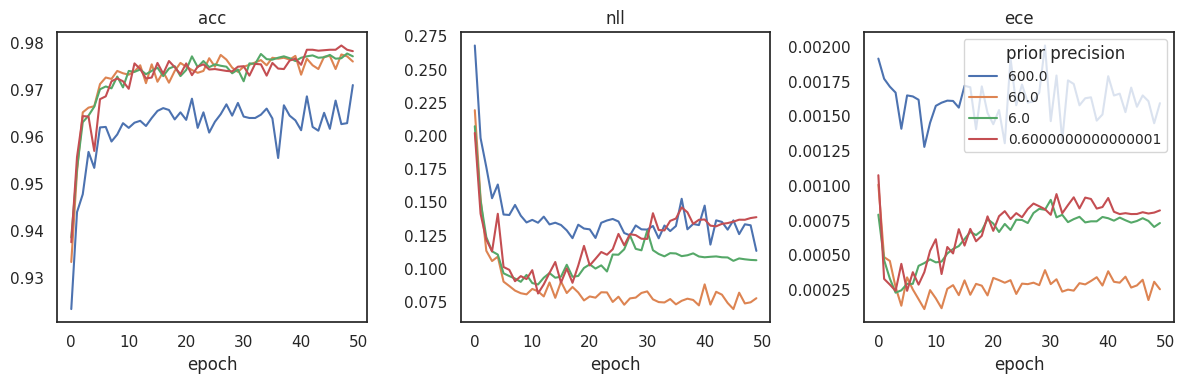

In [18]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

for wd in [1e-2, 1e-3, 1e-4, 1e-5]:
    optim = ivon(
        1e-1,
        ess=datasize,
        hess_init=1.0,
        weight_decay=wd
    )

    key, _key = jr.split(key)
    _, _, metrics = run_training(_key, nnet, optim, train_ds, test_ds, num_epochs=50, mc_samples=1)
    for j, name in enumerate(['acc', 'nll', 'ece']):
        axes[j].plot(metrics[name], label=f'{datasize*wd}')
        axes[j].set_title(name)
        axes[j].set_xlabel('epoch')

plt.legend(title='prior precision', fontsize=10)
fig.tight_layout()